In [1]:
import json
import pandas as pd
from scipy.stats import mannwhitneyu
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
import os.path
from pymrmr import mRMR
import matplotlib.pyplot as plt
from boruta import BorutaPy
from sklearn.metrics import auc, precision_recall_curve, average_precision_score, PrecisionRecallDisplay
import pandas as pd

/home/ale/.local/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version. The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


# Import raw data

In [2]:
# import data from csv 
cnv = pd.read_csv('dataset_hg19/dataset/cnv.csv', sep=' ')
miRNA = pd.read_csv('dataset_hg19/dataset/mirna.csv', sep=' ')
mRNA = pd.read_csv('dataset_hg19/dataset/mrna.csv', sep=' ')
proteins = pd.read_csv('dataset_hg19/dataset/proteins.csv', sep=' ')

In [3]:
label = pd.read_csv('dataset_hg19/dataset/labels_pfi.csv', sep=' ')

In [4]:
def store_filtered_normalize_data(dataset_dict):
    mkdir_p('filtered_normalize_data')
    filtered_normalize_data = create_data_normalized_filtered(dataset_dict, MinMaxScaler, 0.05)
    for data in dataset_dict:
        filtered_normalize_data[data].to_json('filtered_normalize_data/'+data+'.json')

In [5]:
def load_filtered_normalize_data(dataset_dict):
    dict_test = {}
    if os.path.exists('filtered_normalize_data'):
        for data in dataset_dict:
            with open('filtered_normalize_data/'+data+'.json', 'r') as fp:
                dataset = pd.read_json(fp)
                dict_test[data] = dataset
        return dict_test
    else:
        store_filtered_normalize_data(dataset_dict)
        load_filtered_normalize_data(dataset_dict)

In [6]:
dataset_dict = {'cnv': cnv, 'miRNA': miRNA, 'mRNA': mRNA, 'proteins': proteins}

datasets = load_filtered_normalize_data(dataset_dict)

# Create concatenation of all dataset

In [7]:
dataset_concat = pd.concat([datasets['cnv'], datasets['proteins'], datasets['mRNA'], datasets['miRNA']], axis=1)

In [8]:
datasets['concat'] = dataset_concat

# Remove correlated feature using R code

In [9]:
# applicare remove correlated di R per buttare via features.
# poi usare prima mannwhtiney da solo e poi applicare le mann+multivariate, sopratutto con mRNA che ha 20k features.
# l'idea e' di avere una funzione che addestra che mi sputa gli score, il modello addestrato 
# + le feature che ha usato sui fold per addestrare 
# usare poi quelle per applicare multivariate

In [10]:
robjects.r("""
install.packages('caret')
""")

R[write to console]: Installazione pacchetto in ‘/usr/local/lib/R/site-library’
(perché ‘lib’ non è specificato)

R[write to console]: apertura URL 'https://cloud.r-project.org/src/contrib/caret_6.0-93.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 2273775 bytes (2.2 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to con

gcc -I"/usr/share/R/include" -DNDEBUG      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-Faorqz/r-base-4.2.2.20221110=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c caret.c -o caret.o
gcc -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o caret.so caret.o -L/usr/lib/R/lib -lR


** data
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (caret)
R[write to console]: 

R[write to console]: 
R[write to console]: I pacchetti scaricati con il codice sorgente sono in
	‘/tmp/RtmpKdfOsL/downloaded_packages’
R[write to console]: 
R[write to console]: 



<rpy2.rinterface.NULLType object at 0x7fec59d50980> [RTYPES.NILSXP]

In [11]:
robjects.r("""
library(doParallel)
""")

R[write to console]: Caricamento del pacchetto richiesto: foreach

R[write to console]: Caricamento del pacchetto richiesto: iterators

R[write to console]: Caricamento del pacchetto richiesto: parallel



'doParall...,'parallel','iterators',...,'datasets','methods','base'


In [12]:
robjects.r("""
remove_correlated_par <- function(df, dim_split = 1000, maxiter = 5, method = "pearson", cutoff = 0.8){
  
  #df has features on columns
  X = t(df)
  niter = 0
  if (!is.finite(dim_split)) dim_split = nrow(X)
  cat("dim(X) before starting remove correlation: ", dim(X), "\n")
  while(niter < maxiter ){
    cat("niter = ", niter, '\n')
    filtered_X = NULL
    
    cl <- makeCluster(4)
    registerDoParallel(cl)
    
    filtered_X = foreach(nR = seq(1, nrow(X), by=dim_split), 
                         .combine='rbind', .packages = c("caret")) %dopar% {
                           
         subX = X[nR:min(nrow(X), (nR+dim_split-1)), ]
         cc = cor(t(subX), use = "pairwise.complete.obs", method = "kendall")
         
         select_corr = caret::findCorrelation(cc, cutoff = cutoff, exact = FALSE)
         #print(length(select_corr))
         
         if (length(select_corr)>0){ 
           subX = subX[-select_corr, ]
         }
         
         return(subX)
           
     }
    
    stopCluster(cl)
    
    print(names(filtered_X))
    #    if (length(unique(filtered_X[,1]))>1) cat('PROBLEMA!')
    no_removed = nrow(X)-nrow(filtered_X)
    cat('Removed = ', no_removed, '\n')
    cat('dim filetered_X =', dim(filtered_X), '\n')

    X = filtered_X[sample(nrow(filtered_X)), ]
    
    niter = niter + 1
    cat("nrow(X) =", dim(X), '\n')
    if (no_removed ==0) break;
  }
  cat('final dimension = ', dim(t(X)), '\n')
  
  
  return(t(X))
    }
    """)

R object with classes: ('function',) mapped to:

# Convert data in a r structure data

In [13]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_proteins = robjects.conversion.py2rpy(datasets['proteins'])

/home/ale/.local/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:53: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [14]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_miRNA = robjects.conversion.py2rpy(datasets['miRNA'])

In [15]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_mRNA = robjects.conversion.py2rpy(datasets['mRNA'])

In [16]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_cnv = robjects.conversion.py2rpy(datasets['cnv'])

In [17]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_concat = robjects.conversion.py2rpy(datasets['concat'])

# Store data in local

In [18]:
def compute_and_save_result(data, path):
    data_removed = robjects.globalenv["remove_correlated_par"](data)
    df = pd.DataFrame(data=np.array(data_removed), columns=data_removed.colnames)
    df.to_json(path)
    
def restore_result(file_name):
    return pd.read_json(f'elaborated_data_r_mannwhtiney_and_multivariate_feature_selection/{file_name}.json')

def load_or_store_removed_correlated(data, file_name):
    if os.path.exists(f'elaborated_data_r_mannwhtiney_and_multivariate_feature_selection/{file_name}.json'):
        return restore_result(file_name)
    else:
        compute_and_save_result(data, f'elaborated_data_r_mannwhtiney_and_multivariate_feature_selection/{file_name}.json')
        return restore_result(file_name)

In [19]:
df_proteins_removed = load_or_store_removed_correlated(r_proteins, 'r_proteins_removed')

In [20]:
df_mirna_removed = load_or_store_removed_correlated(r_miRNA, 'r_mirna_removed')

In [21]:
df_mrna_removed = load_or_store_removed_correlated(r_mRNA, 'r_mrna_removed')

In [22]:
df_cnv_removed = load_or_store_removed_correlated(r_cnv, 'r_cnv_removed')

In [23]:
df_concat_removed = load_or_store_removed_correlated(r_concat, 'r_concat_removed')

In [24]:
print('DATI MANIPOLATI CON LA FUNZIONE R ELIMINANDO LE FEATURE CORRELATE')

DATI MANIPOLATI CON LA FUNZIONE R ELIMINANDO LE FEATURE CORRELATE


# Mann-Whitney

In [25]:
def create_dataframe_pos_neg(dataset, label):
    mask_1 = label['x']==1
    mask_0 = label['x']==0
    return (dataset[mask_1.to_list()], dataset[mask_0.to_list()])

In [26]:
def mann_whitney_features_selection(dataset, label, min_pValue):
    pos, neg = create_dataframe_pos_neg(dataset, label)
    H, pval = mannwhitneyu(pos, neg)
    mask = (pval < min_pValue)
    return dataset.columns[mask]

# Multivariate feature selection, mrmr and Boruta 

In [27]:
def execute_mrmr(dataset, n_feature):
    return mRMR(dataset, 'MIQ', n_feature)

In [28]:
def execute_boruta_feature_selection(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    holdout_number: int,
    max_iter: int = 100,
):
    """Returns tuple with list of kept features and list of discared features.
    
    Parameters
    --------------------------
    X_train: pd.DataFrame,
        The data reserved for the input of the training of the Boruta model.
    y_train: np.ndarray,
        The data reserved for the output of the training of the Boruta model.
    holdout_number: int,
        The current holdout number.
    max_iter: int = 100,
        Number of iterations to run Boruta for.
    """

    model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5)
    
    boruta_selector = BorutaPy(
        model,
        n_estimators='auto',
        verbose=False,
        alpha=0.05,
        max_iter=max_iter, 
        random_state=42,
    )
    boruta_selector.fit(X_train.values, y_train.values.ravel())
    
    kept_features = list(X_train.columns[boruta_selector.support_])
    discarded_features = list(X_train.columns[~boruta_selector.support_])
    
    return kept_features, discarded_features

# Train

In [29]:
def train_using_mann_whitney(X,
                            label, 
                            num_external_fold,
                            type_dataset, 
                            tecnique_feature_selection,
                            path):
    
    aucs = []
    y_score_concatenated = []
    y_test_fold_concatenated = []
    list_selected_feature = {}
    iteration = 0
    result_dict = {}
    result_dict[type_dataset] = {}
    result_dict[type_dataset][tecnique_feature_selection] = {} 
    
   
    X_numpy = X.to_numpy()
    label_numpy = label['x'].to_numpy()
    
    external_fold = StratifiedKFold(n_splits=num_external_fold, shuffle=True, random_state=1)
    
    for train_index, test_index in tqdm(external_fold.split(X, label_numpy), desc=f"Running fold ", dynamic_ncols=True, leave=False):
        
        X_train_fold, X_test_fold = X_numpy[train_index], X_numpy[test_index]
        y_train_fold, y_test_fold = label_numpy[train_index], label_numpy[test_index]
        
        df_X_train = pd.DataFrame(data=X_train_fold, columns=X.columns)
        df_X_test = pd.DataFrame(data=X_test_fold, columns=X.columns)
        df_y_train = pd.DataFrame(data=y_train_fold, columns=label.columns)
        
        selected_features = mann_whitney_features_selection(df_X_train, df_y_train, 0.05)
        
        iteration = iteration + 1
        list_selected_feature[iteration] = selected_features
        
        X_train_selected_feature = df_X_train[selected_features]
        X_test_selected_feature = df_X_test[selected_features]
        
        clf = GridSearchCV(estimator=RandomForestClassifier(),
                   scoring='average_precision',
                   param_grid=model_selection_grid_DT, 
                   cv=2, 
                   n_jobs=-1)
        clf.fit(X_train_selected_feature, y_train_fold)
        
        # Get the predicited probability of testing data
        y_score = clf.predict_proba(X_test_selected_feature)[:, 1]
        
        #calculate precision and recall
        precision, recall, thresholds = precision_recall_curve(y_test_fold, y_score)

        #plot_precision_recall_curve(classifier, X_test_selected_feature, y_test_fold)
        
        y_score_concatenated = np.concatenate((y_score_concatenated, y_score), axis=None)
        y_test_fold_concatenated = np.concatenate((y_test_fold_concatenated, y_test_fold), axis=None)
        
        
        # Use AUC function to calculate the area under the curve of precision recall curve
        auc_precision_recall = auc(recall, precision)
        
        aucs.append(auc_precision_recall)
        #print('auc: {:.3f} using params {}:'.format(auc_precision_recall, clf.best_params_))
    
    internal_auc = np.mean(aucs)
    
    #calculate precision and recall
    precision, recall, thresholds = precision_recall_curve(y_test_fold_concatenated, y_score_concatenated)
    
    external_auc = auc(recall, precision)
    #plot precision recall curve
    PrecisionRecallDisplay.from_predictions(y_test_fold_concatenated, y_score_concatenated)
    
    result_dict[type_dataset][tecnique_feature_selection]['internal'] = '{0:.4f}'.format(internal_auc)
    result_dict[type_dataset][tecnique_feature_selection]['external'] = '{0:.4f}'.format(external_auc)
    result_dict[type_dataset][tecnique_feature_selection]['best_estimator'] = str(clf.best_estimator_)
    result_dict[type_dataset][tecnique_feature_selection]['feature_used'] = str(list_selected_feature)
    
    plt.savefig(path+tecnique_feature_selection+'/'+type_dataset+'_'+'AUC_External.pdf')
    
    with open(path+tecnique_feature_selection+'/'+type_dataset+'.json', 'w', encoding='utf-8') as fp:
        json.dump(result_dict[type_dataset], fp, ensure_ascii=False, indent=4)
    #plt.show()    
    
    return list_selected_feature

# GridSearch

In [30]:
model_selection_grid_DT = [
    {'criterion': ['gini', 'entropy'],
     'max_leaf_nodes': [None, 2, 5, 10],
     'max_features': [None, 'sqrt', 'log2'],
    'n_estimators': [51, 101, 251, 500]}
]

# Train using multivariate feature selection after mannwhitney

In [35]:
def train_using_multivariate(X,
                             label,
                             list_selected_feature_from_mannwhiney, 
                             num_external_fold,
                             tecnique_feature_selection,
                             path,
                             type_dataset,
                             type_feature_selection=None):
    
    aucs = []
    iteration = 0
    y_score_concatenated = []
    y_test_fold_concatenated = []
    result_dict = {}
    result_dict[type_dataset] = {}
    result_dict[type_dataset][type_feature_selection] = {} 
    
    X_numpy = X.to_numpy()
    label_numpy = label['x'].to_numpy()
    
    external_fold = StratifiedKFold(n_splits=num_external_fold, shuffle=True, random_state=1)
    
    for (train_index, test_index), selected_features in zip(tqdm(external_fold.split(X, label_numpy), desc=f"Running fold ", dynamic_ncols=True, leave=False), list_selected_feature_from_mannwhiney.values()):
        
        X_train_fold, X_test_fold = X_numpy[train_index], X_numpy[test_index]
        y_train_fold, y_test_fold = label_numpy[train_index], label_numpy[test_index]
        
        df_X_train = pd.DataFrame(data=X_train_fold, columns=X.columns)
        df_X_test = pd.DataFrame(data=X_test_fold, columns=X.columns)
        df_y_train = pd.DataFrame(data=y_train_fold, columns=label.columns)
        
        #TAKE FEATURES FROM MANNWHINEY
        X_train_selected_feature = df_X_train[selected_features]
        X_test_selected_feature = df_X_test[selected_features]
        
        print(f'TRAIN:{X_train_selected_feature}')
        print('*'*10)
       
        if type_feature_selection == "mrmr":
            selected_features = execute_mrmr(X_train_selected_feature, 100)
        elif type_feature_selection == 'boruta':
            selected_features, discarded_feature =  execute_boruta_feature_selection(X_train_selected_feature, df_y_train, 5)
        
        X_train_selected_feature = X_train_selected_feature[selected_features]
        X_test_selected_feature = X_test_selected_feature[selected_features]
        
        
        clf = GridSearchCV(estimator=RandomForestClassifier(),
                   scoring='average_precision',
                   param_grid=model_selection_grid_DT, 
                   cv=2, 
                   n_jobs=-1)
        clf.fit(X_train_selected_feature, y_train_fold)
        
        # Get the predicited probability of testing data
        y_score = clf.predict_proba(X_test_selected_feature)[:, 1]
        
        #calculate precision and recall
        precision, recall, thresholds = precision_recall_curve(y_test_fold, y_score)

        #plot_precision_recall_curve(classifier, X_test_selected_feature, y_test_fold)
        
        y_score_concatenated = np.concatenate((y_score_concatenated, y_score), axis=None)
        y_test_fold_concatenated = np.concatenate((y_test_fold_concatenated, y_test_fold), axis=None)
        
        
        # Use AUC function to calculate the area under the curve of precision recall curve
        auc_precision_recall = auc(recall, precision)
        
        aucs.append(auc_precision_recall)
        #print('auc: {:.3f} using params {}:'.format(auc_precision_recall, clf.best_params_))
    
    internal_auc = np.mean(aucs)
    
    #calculate precision and recall
    precision, recall, thresholds = precision_recall_curve(y_test_fold_concatenated, y_score_concatenated)
    
    external_auc = auc(recall, precision)
    #plot precision recall curve
    PrecisionRecallDisplay.from_predictions(y_test_fold_concatenated, y_score_concatenated)
    #plt.show()
    
    result_dict[type_dataset][type_feature_selection]['internal'] = '{0:.4f}'.format(internal_auc)
    result_dict[type_dataset][type_feature_selection]['external'] = '{0:.4f}'.format(external_auc)
    result_dict[type_dataset][type_feature_selection]['best_estimator'] = str(clf.best_estimator_)
    result_dict[type_dataset][type_feature_selection]['feature_used'] = str(list_selected_feature)
    
    plt.savefig(path+tecnique_feature_selection+type_dataset+'_'+'AUC_External.pdf')
    
    with open(path+tecnique_feature_selection+'/'+type_dataset+'.json', 'w', encoding='utf-8') as fp:
        json.dump(result_dict[type_dataset], fp, ensure_ascii=False, indent=4)
    
    return list_selected_feature

# Train proteins

In [100]:
list_selected_feature = train_using_mann_whitney(df_proteins_removed, label, 10, 'proteins', 'r_function_with_mannwhitney', 'result_new_experiment/')

TypeError: the JSON object must be str, bytes or bytearray, not TextIOWrapper

In [74]:
train_using_multivariate(df_proteins_removed, label, list_selected_feature, 10,
                         'r_function_with_mannwhitney_mrmr/', 
                         'result_new_experiment/',
                         'proteins',
                         'mrmr')

In [75]:
train_using_multivariate(df_proteins_removed, label, list_selected_feature, 2,
                         'r_function_with_mannwhitney_boruta/', 
                         'result_new_experiment/',
                         'proteins',
                         'boruta')

# Train miRNA 

In [87]:
list_selected_feature = train_using_mann_whitney(df_mirna_removed, label, 10, 'mirna', 'r_function_with_mannwhitney', 'result_new_experiment/')

In [77]:
train_using_multivariate(df_mirna_removed, label, list_selected_feature, 10,
                         'r_function_with_mannwhitney_mrmr/', 
                         'result_new_experiment/',
                         'mirna',
                         'mrmr')

In [78]:
train_using_multivariate(df_mirna_removed, label, list_selected_feature, 10,
                         'r_function_with_mannwhitney_boruta/', 
                         'result_new_experiment/',
                         'mirna',
                         'boruta')

# Train mrna

In [126]:
list_selected_feature = train_using_mann_whitney(df_mrna_removed, label, 10, 'mrna', 'r_function_with_mannwhitney', 'result_new_experiment/')

KeyboardInterrupt: 

In [80]:
train_using_multivariate(df_mrna_removed, label, list_selected_feature, 10,
                         'r_function_with_mannwhitney_mrmr/', 
                         'result_new_experiment/',
                         'mrna',
                         'mrmr')

AttributeError: 'str' object has no attribute 'values'

In [81]:
train_using_multivariate(df_mrna_removed, label, list_selected_feature, 10,
                         'r_function_with_mannwhitney_boruta/', 
                         'result_new_experiment/',
                         'mrna',
                         'boruta')

AttributeError: 'str' object has no attribute 'values'

# Train cnv

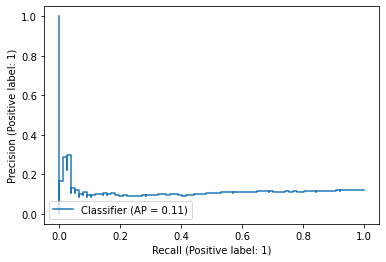

In [127]:
list_selected_feature = train_using_mann_whitney(df_cnv_removed, label, 10, 'cnv', 'r_function_with_mannwhitney', 'result_new_experiment/')

In [83]:
train_using_multivariate(df_cnv_removed, label, list_selected_feature, 10,
                         'r_function_with_mannwhitney_mrmr/', 
                         'result_new_experiment/',
                         'cnv',
                         'mrmr')

In [128]:
train_using_multivariate(df_cnv_removed, label, list_selected_feature, 10,
                         'r_function_with_mannwhitney_boruta/', 
                         'result_new_experiment/',
                         'cnv',
                         'boruta')

Running fold : 0it [00:00, ?it/s]

TRAIN:     ZDHHC13  C19orf40  DLG2  LINC00662  ABR  CAPN12
0          0         0     1          0   -1       0
1          0         0    -1          0   -1       0
2          0         1     0          1   -1       1
3          0         0     0          0    0       0
4          1        -1     1         -1    1      -1
..       ...       ...   ...        ...  ...     ...
559       -1        -1     1         -1   -1      -1
560        0         1     0          1   -1       1
561        0         0     1          0   -1      -1
562        0         0    -1          0    0       0
563       -1         0    -1          0    0       0

[564 rows x 6 columns]
**********


Running fold : 1it [00:06,  6.90s/it]

TRAIN:     ACTN3  C19orf40  DLG2  IGF2BP1  MIR1277  ZNF717  PTPRCAP
0        0         0     1        2       -1      -1        0
1        0         0    -1        2        0       0        0
2        0         0     0        0        0       0        0
3       -1        -1     1        1        0       0       -1
4        0         1     0        0        0       0        0
..     ...       ...   ...      ...      ...     ...      ...
559      1         2     1       -1        0       0        2
560      1        -1     1       -1        0       0        1
561      0         1     0        0        0       0        0
562      0         0    -1        0        0       0        0
563      1         0    -1        0        1      -1        1

[564 rows x 7 columns]
**********


Running fold : 2it [00:13,  6.91s/it]

TRAIN:     ACTN3  DLG2  SMOX  MACROD2  PTPRCAP
0        0    -1     0        0        0
1        0     0     0        0        0
2        0     0     0        0        0
3        0     0     1        1        0
4        0    -1     0        0        2
..     ...   ...   ...      ...      ...
559      1    -1     1        0        1
560      0     1     0        0        0
561      0    -1     0        0        0
562     -1    -1     0        0       -1
563      1    -1     1        1        1

[564 rows x 5 columns]
**********


Running fold : 3it [00:20,  6.87s/it]

TRAIN:     ACTN3  ZDHHC13  L3MBTL4  PTPRCAP
0        0        0       -1        0
1        0        0        0        0
2        0        0        0        0
3        0        0        0        0
4       -1        1        0       -1
..     ...      ...      ...      ...
559      0        0        0        0
560      0        0        0        0
561      0        0        0        0
562     -1       -1        0       -1
563      1        1        0        1

[564 rows x 4 columns]
**********


ValueError: 
All the 192 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
192 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ale/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ale/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    X, y = self._validate_data(
  File "/home/ale/.local/lib/python3.10/site-packages/sklearn/base.py", line 596, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/ale/.local/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1074, in check_X_y
    X = check_array(
  File "/home/ale/.local/lib/python3.10/site-packages/sklearn/utils/validation.py", line 768, in check_array
    dtype_orig = np.result_type(*dtypes_orig)
  File "<__array_function__ internals>", line 5, in result_type
ValueError: at least one array or dtype is required


# Train concat

CHECKKKKKKKK


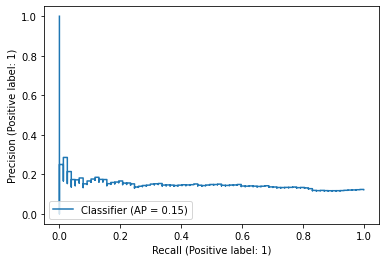

In [36]:
list_selected_feature = train_using_mann_whitney(df_concat_removed, label, 10, 'concat', 'r_function_with_mannwhitney', 'result_new_experiment/')

In [ ]:
train_using_multivariate(df_concat_removed, label, list_selected_feature, 10,
                         'r_function_with_mannwhitney_mrmr/', 
                         'result_new_experiment/',
                         'concat',
                         'mrmr')

In [ ]:
train_using_multivariate(df_concat_removed, label, list_selected_feature, 10,
                         'r_function_with_mannwhitney_boruta/', 
                         'result_new_experiment/',
                         'concat',
                         'boruta')